In [33]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import csv
import glob
import os
import numpy as np
import matplotlib.dates as mdates

In [14]:
# Reads monthly exchange rates from CHF to USD and writes the inverted rates (USD to CHF) to a new file.

input_file = '../data/monthly_exchange_rate/monthly_CHF_to_one_USD.csv'
output_file = '../data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSSZ']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXSZUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSSZ': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [15]:
# Reads monthly exchange rates from JPY to USD and writes the inverted rates (USD to JPY) to a new file.

input_file = '../data/monthly_exchange_rate/monthly_JPY_to_one_USD.csv'
output_file = '../data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSJP']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXJPUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSJP': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [16]:
# loads monthly USD exchange rate data for five currencies, 
# renames the columns for clarity, merges them into a single DataFrame, 
# and saves the result as a CSV file.


# Load exchange rate data for each currency (USD to one unit of foreign currency)
df_chf_rate = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv')
df_jpy_rate = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv')
df_aud_rate = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_AUD.csv')
df_eur_rate = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_EUR.csv')
df_gbp_rate = pd.read_csv('../data/monthly_exchange_rate/monthly_USD_to_one_GBP.csv')

# Rename the columns for clarity, representing the exchange rate from USD to each currency
df_chf_rate.rename(columns={'EXUSSZ': 'USD_per_CHF'}, inplace=True)
df_jpy_rate.rename(columns={'EXUSJP': 'USD_per_JPY'}, inplace=True)
df_aud_rate.rename(columns={'EXUSAL': 'USD_per_AUD'}, inplace=True)
df_eur_rate.rename(columns={'EXUSEU': 'USD_per_EUR'}, inplace=True)
df_gbp_rate.rename(columns={'EXUSUK': 'USD_per_GBP'}, inplace=True)

# Merge all the exchange rate dataframes on the 'date' column, using outer joins to retain all dates
df_merged_rates = df_chf_rate[['date', 'USD_per_CHF']].merge(df_jpy_rate[['date', 'USD_per_JPY']], on='date', how='outer') \
    .merge(df_aud_rate[['date', 'USD_per_AUD']], on='date', how='outer') \
    .merge(df_eur_rate[['date', 'USD_per_EUR']], on='date', how='outer') \
    .merge(df_gbp_rate[['date', 'USD_per_GBP']], on='date', how='outer')

# Save the merged exchange rate data to a new CSV file
df_merged_rates.to_csv('../data/monthly_exchange_rate/merged_monthly_exchange_rates.csv', index=False)

# Display the first few rows of the final merged DataFrame
df_merged_rates.head()

,date,USD_per_CHF,USD_per_JPY,USD_per_AUD,USD_per_EUR,USD_per_GBP
0,2002-01-01,0.5985,0.0075,0.5170,0.8832,1.4322
1,2002-02-01,0.5893,0.0075,0.5128,0.8707,1.4227
2,2002-03-01,0.5973,0.0076,0.5256,0.8766,1.4230
3,2002-04-01,0.6045,0.0076,0.5352,0.8860,1.4429
4,2002-05-01,0.6294,0.0079,0.5498,0.9170,1.4598


In [17]:
# Loads monthly returns data for various countries, merges the data with CRSP (US returns) and T-bills data, 
# and standardizes the columns to include the returns for each country in the correct format, 
# before saving the final merged DataFrame.

import pandas as pd

# Folder path containing the return data files
path = "../data/monthly_returns/"

# List of country-specific return files (excluding 'csrp_return.csv' and 'tbills.csv')
country_files = [
    "australia_return.csv", "france_return.csv", "germany_return.csv",
    "japan_return.csv", "swiss_return.csv", "uk_return.csv"
]

# Initialize an empty DataFrame for storing merged monthly returns data
df_all_country_returns = None

# Load and process country-specific return data files
for file in country_files:
    # Load each country's return file
    df_country_return = pd.read_csv(path + file)

    # Extract country and currency from the first row
    country = df_country_return['country'].iloc[0].lower()   # e.g., "AUSTRALIA" -> "australia"
    currency = df_country_return['currency'].iloc[0].lower() # e.g., "AUD" -> "aud"

    # Standardize the 'date' column to the format YYYY-MM
    df_country_return['date'] = pd.to_datetime(df_country_return['date']).dt.to_period('M').dt.to_timestamp()

    # Keep only relevant columns
    df_country_return = df_country_return[['date', 'mportret', 'mportretx']]

    # Rename columns to include the country and currency
    df_country_return = df_country_return.rename(columns={
        'mportret': f'{country}_ret_with_div_{currency}',
        'mportretx': f'{country}_ret_without_div_{currency}'
    })

    # Merge the current country's data into the final DataFrame
    if df_all_country_returns is None:
        df_all_country_returns = df_country_return
    else:
        df_all_country_returns = pd.merge(df_all_country_returns, df_country_return, on='date', how='outer')

# Load and process the CRSP (US returns) data
df_crsp_returns = pd.read_csv(path + "csrp_return.csv")
df_crsp_returns['date'] = pd.to_datetime(df_crsp_returns['date']).dt.to_period('M').dt.to_timestamp()
df_crsp_returns = df_crsp_returns[['date', 'vwretd', 'vwretx']]
df_crsp_returns = df_crsp_returns.rename(columns={
    'vwretd': 'us_ret_with_div_usd',
    'vwretx': 'us_ret_without_div_usd'
})
# Merge CRSP returns with the existing DataFrame
df_all_country_returns = pd.merge(df_all_country_returns, df_crsp_returns, on='date', how='outer')

# Load and process T-Bills data
df_tbill_returns = pd.read_csv(path + "tbills.csv")
df_tbill_returns['date'] = pd.to_datetime(df_tbill_returns['date']).dt.to_period('M').dt.to_timestamp()
df_tbill_returns = df_tbill_returns[['date', 'rf']]
df_tbill_returns = df_tbill_returns.rename(columns={'rf': 'rf_usd'})
# Merge T-Bills data with the existing DataFrame
df_all_country_returns = pd.merge(df_all_country_returns, df_tbill_returns, on='date', how='outer')

# Sort the final DataFrame by 'date' and reset the index
df_all_country_returns = df_all_country_returns.sort_values('date').reset_index(drop=True)

# Save the final merged DataFrame to a CSV file
df_all_country_returns.to_csv("../data/monthly_returns/merged_returns_with_currency.csv", index=False)

# Display the first few rows of the final merged DataFrame
df_all_country_returns.head()


,date,australia_ret_with_div_aud,australia_ret_without_div_aud,france_ret_with_div_eur,france_ret_without_div_eur,germany_ret_with_div_eur,germany_ret_without_div_eur,japan_ret_with_div_jpy,japan_ret_without_div_jpy,switzerland_ret_with_div_chf,switzerland_ret_without_div_chf,united kingdom_ret_with_div_gbp,united kingdom_ret_without_div_gbp,us_ret_with_div_usd,us_ret_without_div_usd,rf_usd
0,2002-01-01,0.027358,0.027313,-0.027105,-0.027306,0.012277,0.011491,-0.056655,-0.056710,-0.022126,-0.022146,-0.010866,-0.011720,-0.015966,-0.016921,0.0014
1,2002-02-01,-0.001832,-0.004358,-0.004394,-0.004447,-0.008807,-0.008816,0.042256,0.041998,0.011661,0.011646,-0.003341,-0.007072,-0.021700,-0.023066,0.0013
2,2002-03-01,0.005199,-0.001914,0.052081,0.051943,0.049328,0.048470,0.053119,0.048294,0.048759,0.045570,0.038930,0.033661,0.044698,0.043730,0.0013
3,2002-04-01,-0.014302,-0.015424,-0.043988,-0.045755,-0.045031,-0.047093,0.020586,0.020574,-0.004109,-0.007961,-0.013362,-0.015411,-0.049600,-0.050504,0.0015
4,2002-05-01,-0.000204,-0.001752,-0.028016,-0.035487,-0.025703,-0.033068,0.035987,0.035920,0.002963,-0.000639,-0.011482,-0.013937,-0.010510,-0.011958,0.0014


In [ ]:
import pandas as pd
import numpy as np

# Load the previously constructed DataFrame containing country returns
df_country_returns = df_all_country_returns.copy()

# Load the exchange rate data
df_exchange_rates = pd.read_csv("../data/monthly_exchange_rate/merged_monthly_exchange_rates.csv")
df_exchange_rates['date'] = pd.to_datetime(df_exchange_rates['date']).dt.to_period('M').dt.to_timestamp()

# Merge the exchange rate data with the country returns data on 'date'
df_country_returns = pd.merge(df_country_returns, df_exchange_rates, on='date', how='left')

# Mapping from country currencies to the corresponding exchange rate column names
currency_to_fx_col = {
    'aud': 'USD_per_AUD',
    'eur': 'USD_per_EUR',
    'chf': 'USD_per_CHF',
    'jpy': 'USD_per_JPY',
    'gbp': 'USD_per_GBP'
}

# Calculate the return on the exchange rate (Rex)
for curr, fx_col in currency_to_fx_col.items():
    # Calculate the return of the exchange rate
    df_country_returns[f'Rex_{curr}'] = (1 / df_exchange_rates[fx_col]).pct_change()

# Convert all country returns columns to USD using the logarithmic formula
converted_cols = {}

for col in df_country_returns.columns:
    if '_ret_with_div_' in col or '_ret_without_div_' in col:
        for curr, fx_col in currency_to_fx_col.items():
            if col.endswith(f'_{curr}'):
                rex_col = f'Rex_{curr}'  # Corresponding Rex column
                new_col = col.replace(f'_{curr}', '_usd')  # New column name for USD
                # Apply the formula to calculate the USD return
                df_country_returns[new_col] = (1 + df_country_returns[col]) * (1 + df_country_returns[rex_col]) - 1
                converted_cols[col] = new_col
                break

# Keep only the date and the USD-return columns
usd_columns = ['date'] + [col for col in df_country_returns.columns if col.endswith('_usd')]

# Final DataFrame: All returns in USD, sorted by date
df_monthly_return_usd = df_country_returns[usd_columns].sort_values('date').reset_index(drop=True)

# Save the final DataFrame as a CSV
df_monthly_return_usd.to_csv("../data/monthly_returns/monthly_return_all_in_usd.csv", index=False)

# Display the final DataFrame
df_monthly_return_usd.head()


,date,us_ret_with_div_usd,us_ret_without_div_usd,rf_usd,australia_ret_with_div_usd,australia_ret_without_div_usd,france_ret_with_div_usd,france_ret_without_div_usd,germany_ret_with_div_usd,germany_ret_without_div_usd,japan_ret_with_div_usd,japan_ret_without_div_usd,switzerland_ret_with_div_usd,switzerland_ret_without_div_usd,united kingdom_ret_with_div_usd,united kingdom_ret_without_div_usd
0,2002-01-01,-0.015966,-0.016921,0.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-02-01,-0.021700,-0.023066,0.0013,0.006343,0.003797,0.009899,0.009845,0.005423,0.005414,0.042256,0.041998,0.027454,0.027439,0.003314,-0.000442
2,2002-03-01,0.044698,0.043730,0.0013,-0.019281,-0.026221,0.045000,0.044863,0.042266,0.041413,0.039262,0.034501,0.034713,0.031566,0.038711,0.033443
3,2002-04-01,-0.049600,-0.050504,0.0015,-0.031983,-0.033085,-0.054131,-0.055879,-0.055162,-0.057203,0.020586,0.020574,-0.015970,-0.019777,-0.026969,-0.028990
4,2002-05-01,-0.010510,-0.011958,0.0014,-0.026753,-0.028260,-0.060875,-0.068093,-0.058640,-0.065756,-0.003354,-0.003419,-0.036716,-0.040175,-0.022926,-0.025353


In [52]:
# This code processes the interbank rate data for multiple countries, 
# merges them into a single DataFrame with the date as the index, 
# and renames the columns to explicitly indicate the three-month interbank rates for each country 
# (AUD, CHF, EUR, GBP, JPY, US).


# Define the path to the folder containing the interbank rate files
path = "../data/three_month_interbank_rate/"

# List of country files (with the format country_three_month_interbank_rate)
country_files = [
    "three_month_interbank_rate_AUD.csv", 
    "three_month_interbank_rate_CH.csv", 
    "three_month_interbank_rate_EUR.csv",
    "three_month_interbank_rate_GBP.csv", 
    "three_month_interbank_rate_JPY.csv", 
    "three_month_interbank_rate_US.csv"
]

# Initialize the final merged DataFrame with None
df_three_month_rates_merged = None

# Loop through each file and process the data
for file in country_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path + file)

    # Extract country name from the filename (assume the pattern is 'three_month_interbank_rate_<country>.csv')
    country = file.split('_')[4].split('.')[0].lower()  # e.g. 'AUD' for Australia

    # Rename the columns for better understanding with explicit names
    df = df.rename(columns={
        df.columns[1]: f'three_month_interbank_rate_{country.upper()}'  # Explicit column names
    })

    # Convert 'observation_date' to datetime and standardize the format to YYYY-MM
    df['observation_date'] = pd.to_datetime(df['observation_date']).dt.to_period('M').dt.to_timestamp()

    # Keep only the 'observation_date' and the relevant rate column
    df = df[['observation_date', f'three_month_interbank_rate_{country.upper()}']]

    # Merge with the final DataFrame
    if df_three_month_rates_merged is None:
        df_three_month_rates_merged = df
    else:
        df_three_month_rates_merged = pd.merge(df_three_month_rates_merged, df, on='observation_date', how='outer')

# Sort the final merged DataFrame by 'observation_date'
df_three_month_rates_merged = df_three_month_rates_merged.sort_values('observation_date').reset_index(drop=True)

# Rename the 'observation_date' column to 'date' for consistency
df_three_month_rates_merged.rename(columns={'observation_date': 'date'}, inplace=True)

# Iterate through all currency columns to check for missing values
currency_columns = [col for col in df_three_month_rates_merged.columns if 'three_month_interbank_rate_' in col]

# Check for missing values for each currency and print the dates associated
for col in currency_columns:
    missing_data = df_three_month_rates_merged[df_three_month_rates_merged[col].isna()]
    
    if not missing_data.empty:
        print(f"Missing data for {col.split('_')[-1].upper()}:")
        print(missing_data[['date', col]])
        print("\n")

Missing data for JPY:
        date  three_month_interbank_rate_JPY
0 2002-01-01                             NaN
1 2002-02-01                             NaN
2 2002-03-01                             NaN


Missing data for US:
          date  three_month_interbank_rate_US
219 2020-04-01                            NaN




In [53]:
# Fills missing values in the JPY and US three-month interbank rate series by propagating the April 2002 value backward 
# for JPY (Jan–Mar 2002) and by averaging March and May 2020 for the missing US value in April 2020, 
# then saves the cleaned dataset to a CSV file.


# --- Fill missing JPY values (Jan–Mar 2002) with April 2002 value ---
jpy_col = 'three_month_interbank_rate_JPY'
jpy_april_val = df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2002-04-01'), jpy_col
].values[0]

# Fill for Jan, Feb, Mar 2002
mask_jpy_missing = df_three_month_rates_merged['date'].isin([
    pd.Timestamp('2002-01-01'),
    pd.Timestamp('2002-02-01'),
    pd.Timestamp('2002-03-01')
])
df_three_month_rates_merged.loc[mask_jpy_missing, jpy_col] = jpy_april_val

# --- Fill missing US value (April 2020) with average of March and May 2020 ---
us_col = 'three_month_interbank_rate_US'
us_mar_val = df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-03-01'), us_col
].values[0]
us_may_val = df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-05-01'), us_col
].values[0]

# Compute the mean if both values are not NaN
us_avg = np.nanmean([us_mar_val, us_may_val])

# Set April 2020 value
df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-04-01'), us_col
] = us_avg


# Save the merged DataFrame to a CSV file
df_three_month_rates_merged.to_csv(f"{path}/merged_three_month_interbank_rates.csv", index=False)

# Display the final DataFrame
df_three_month_rates_merged.head()

,date,three_month_interbank_rate_AUD,three_month_interbank_rate_CH,three_month_interbank_rate_EUR,three_month_interbank_rate_GBP,three_month_interbank_rate_JPY,three_month_interbank_rate_US
0,2002-01-01,4.26,1.603725,3.338773,4.04677,0.10,1.74
1,2002-02-01,4.31,1.566671,3.357100,4.05268,0.10,1.82
2,2002-03-01,4.46,1.604164,3.390800,4.13055,0.10,1.91
3,2002-04-01,4.59,1.460647,3.406905,4.17319,0.10,1.87
4,2002-05-01,4.84,1.163494,3.467136,4.15370,0.08,1.82


3.a) Compute the returns to each of the stock market indexes in USD by converting the
local currency returns into USD using the appropriate exchange rate

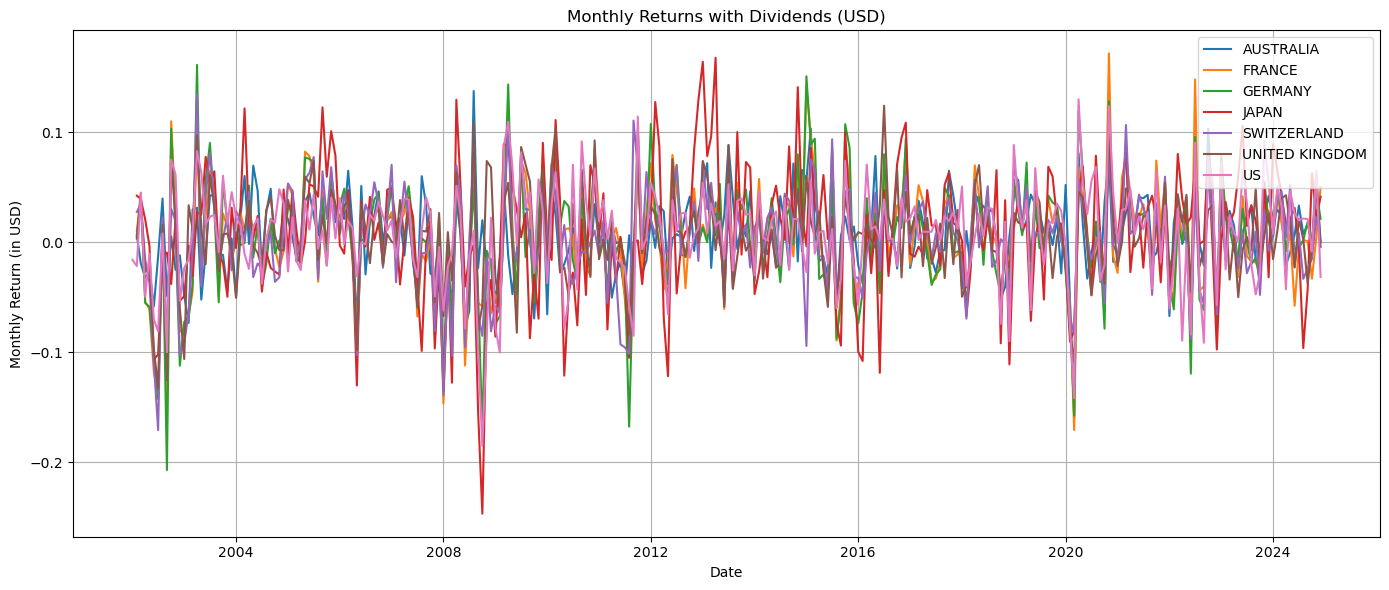

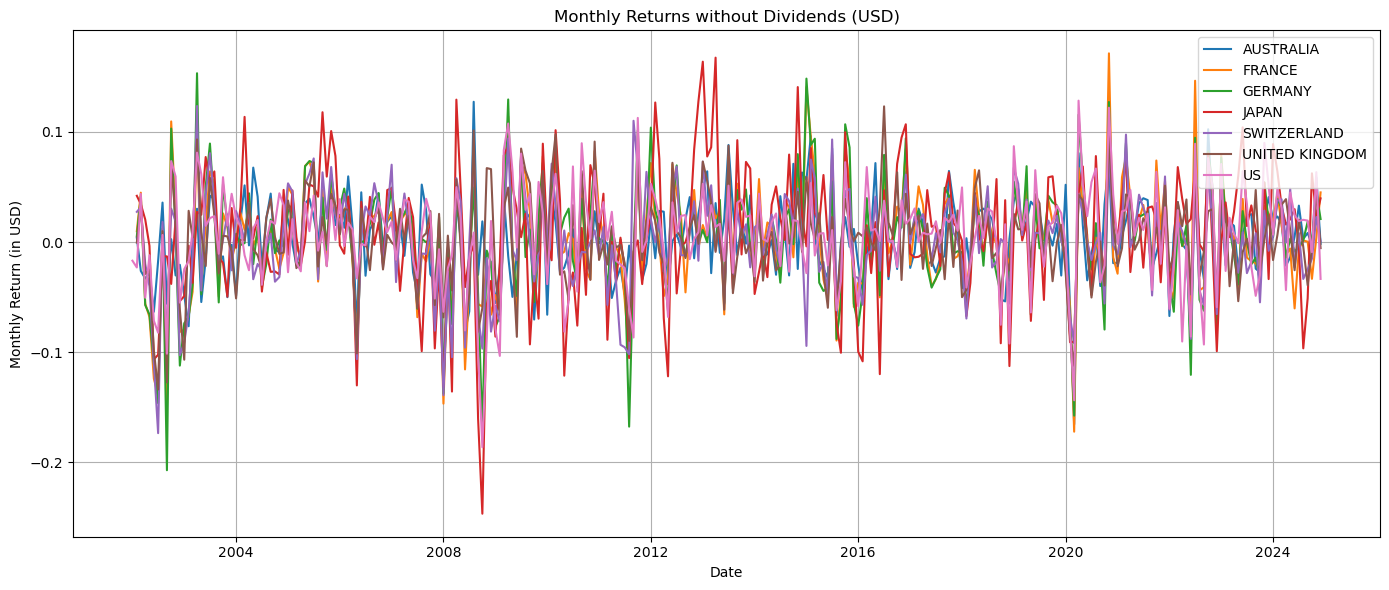

In [54]:
# Separates the monthly returns data into two categories: 
# with dividends and without dividends, and then plots the returns over time 
# for each category (with and without dividends), including the US returns.


# Separate columns for returns with dividends and without dividends
cols_with_div = [col for col in df_monthly_return_usd.columns if 'ret_with_div_usd' in col and col != 'us_ret_with_div_usd']
cols_without_div = [col for col in df_monthly_return_usd.columns if 'ret_without_div_usd' in col and col != 'us_ret_without_div_usd']

# Add US returns (from CRSP) to both lists
cols_with_div.append('us_ret_with_div_usd')
cols_without_div.append('us_ret_without_div_usd')

# Function to plot returns
def plot_returns(df, cols, title):
    plt.figure(figsize=(14, 6))  # Set figure size
    for col in cols:
        # Plot each column's returns against the date
        plt.plot(df['date'], df[col], label=col.replace('_ret_with_div_usd', '').replace('_ret_without_div_usd', '').upper())
    plt.title(title)  # Set the title of the plot
    plt.xlabel('Date')  # Label for the x-axis
    plt.ylabel('Monthly Return (in USD)')  # Label for the y-axis
    plt.legend(loc='upper right')  # Position the legend
    plt.grid(True)  # Display grid lines
    plt.tight_layout()  # Adjust layout for better fitting
    plt.show()  # Display the plot

# Plot returns with dividends
plot_returns(df_monthly_return_usd, cols_with_div, 'Monthly Returns with Dividends (USD)')

# Plot returns without dividends
plot_returns(df_monthly_return_usd, cols_without_div, 'Monthly Returns without Dividends (USD)')

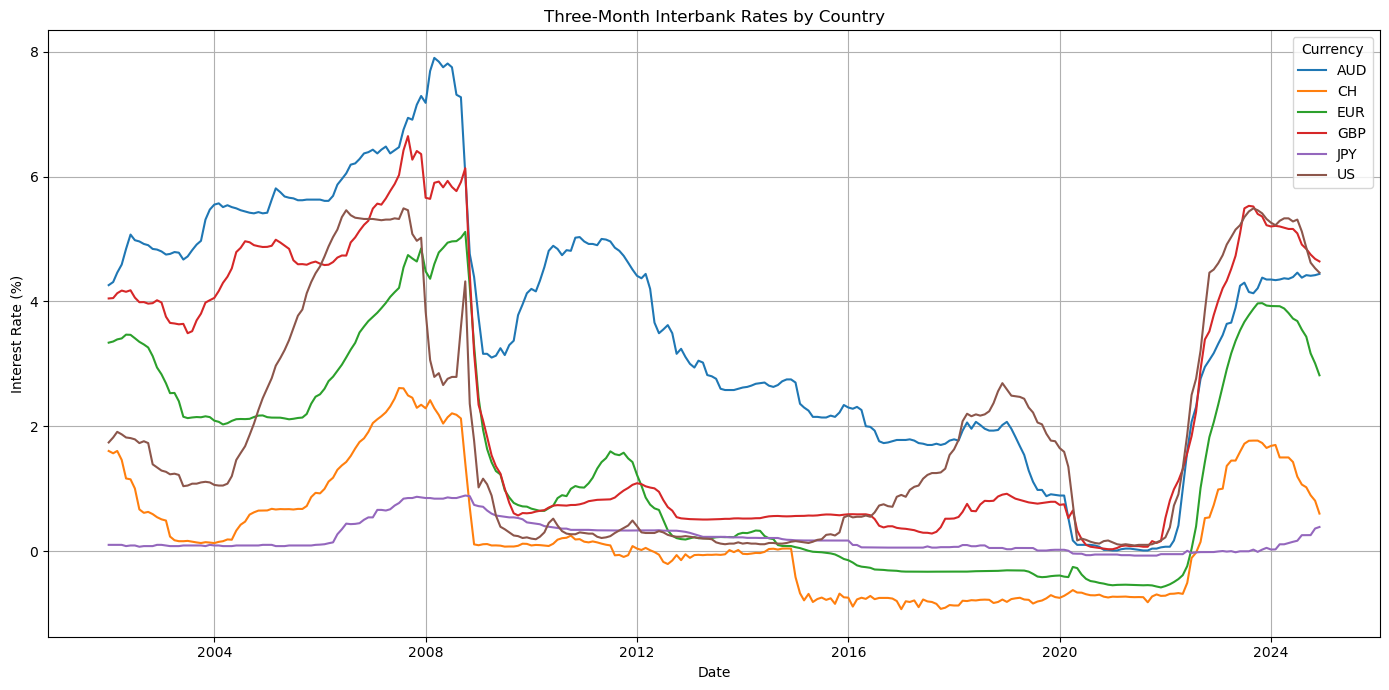

In [55]:
# Identify all columns related to 3-month interbank rates
interbank_rate_cols = [col for col in df_three_month_rates_merged.columns if col.startswith('three_month_interbank_rate_')]

# Plot all interbank rates
plt.figure(figsize=(14, 7))
for col in interbank_rate_cols:
    country_code = col.split('_')[-1]
    plt.plot(df_three_month_rates_merged['date'], df_three_month_rates_merged[col], label=country_code)

plt.title('Three-Month Interbank Rates by Country')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend(title='Currency')
plt.grid(True)
plt.tight_layout()
plt.show()

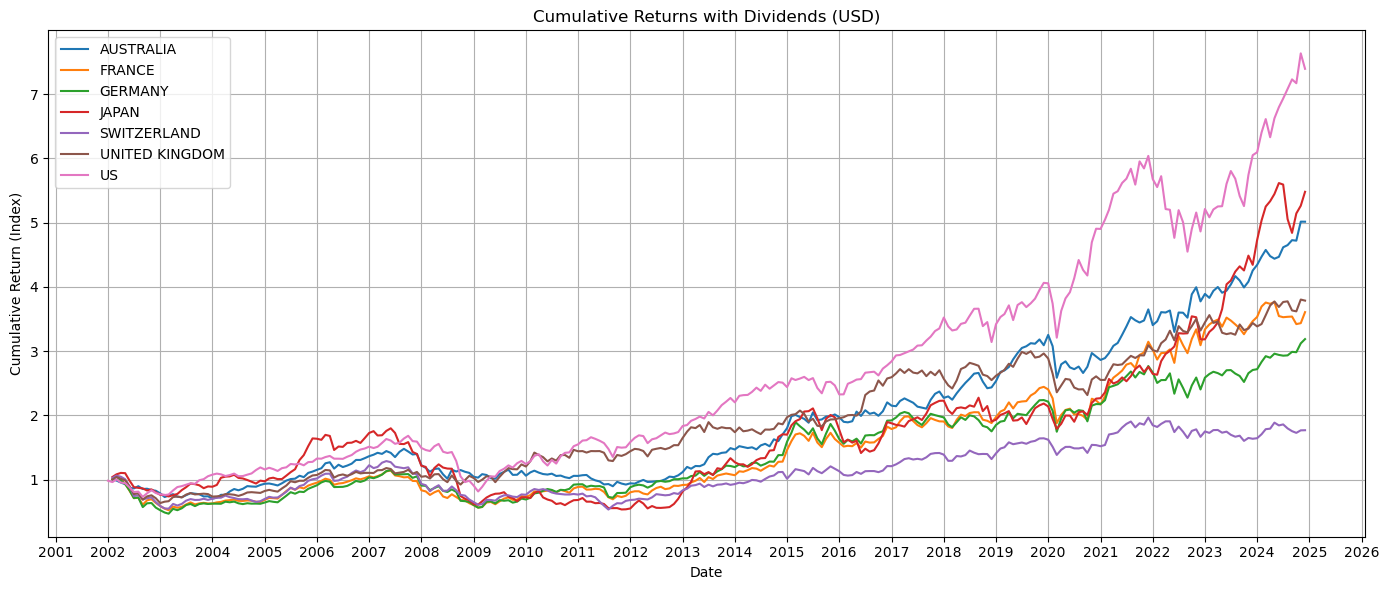

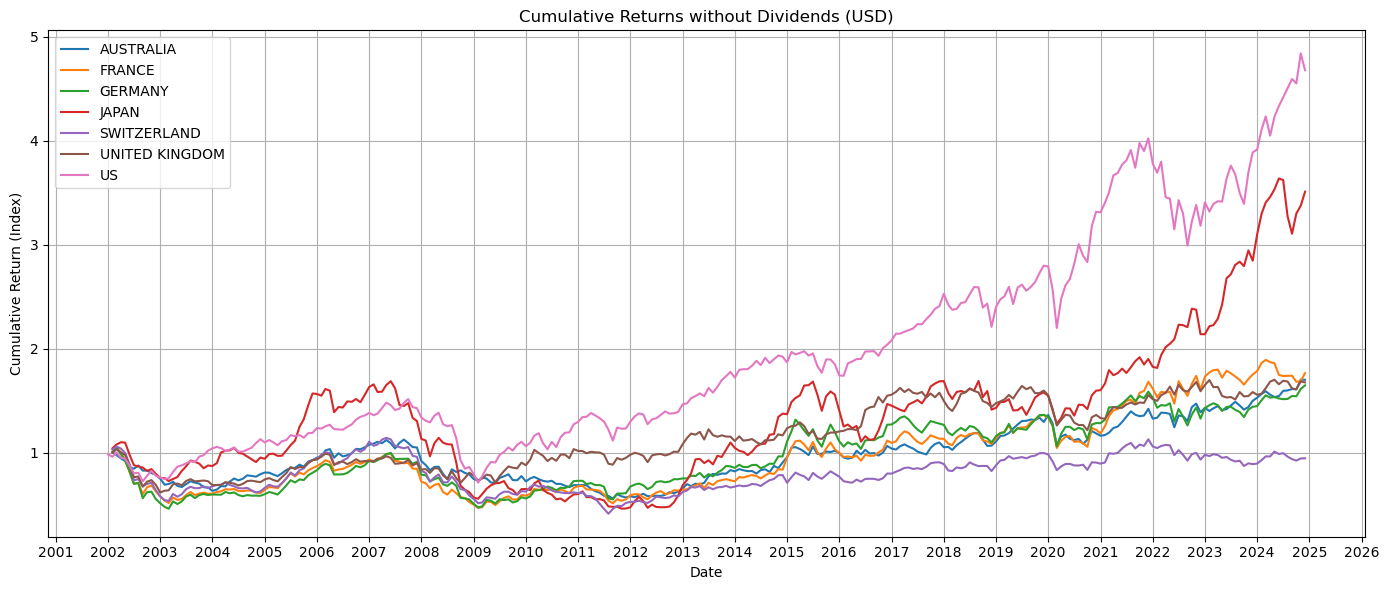

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Separate columns for returns with dividends and without dividends
cols_with_div = [col for col in df_monthly_return_usd.columns if 'ret_with_div_usd' in col and col != 'us_ret_with_div_usd']
cols_without_div = [col for col in df_monthly_return_usd.columns if 'ret_without_div_usd' in col and col != 'us_ret_without_div_usd']

# Add US returns (from CRSP) to both lists
cols_with_div.append('us_ret_with_div_usd')
cols_without_div.append('us_ret_without_div_usd')

# Ensure 'date' is in datetime format
df_monthly_return_usd['date'] = pd.to_datetime(df_monthly_return_usd['date'])

# Function to plot cumulative returns
def plot_cumulative_returns(df, cols, title):
    plt.figure(figsize=(14, 6))  # Set figure size
    for col in cols:
        # Compute cumulative return
        cumulative_return = (1 + df[col]).cumprod()
        label = col.replace('_ret_with_div_usd', '').replace('_ret_without_div_usd', '').upper()
        plt.plot(df['date'], cumulative_return, label=label)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Index)')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Show only years on the x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.tight_layout()
    plt.show()

# Plot cumulative returns with dividends
plot_cumulative_returns(df_monthly_return_usd, cols_with_div, 'Cumulative Returns with Dividends (USD)')

# Plot cumulative returns without dividends
plot_cumulative_returns(df_monthly_return_usd, cols_without_div, 'Cumulative Returns without Dividends (USD)')


In [ ]:
# Q3b

# Load data
df_returns = pd.read_csv("../data/monthly_returns/merged_returns_with_currency.csv", parse_dates=["date"])
df_fx_rf = pd.read_csv("../data/three_month_interbank_rate/merged_three_month_interbank_rates.csv", parse_dates=["date"])
df_exchange_rates = pd.read_csv("../data/monthly_exchange_rate/merged_monthly_exchange_rates.csv", parse_dates=["date"])

# Merge datasets on the date column and sort chronologically
df = pd.merge(df_returns, df_fx_rf, on="date", how="inner")
df = pd.merge(df, df_exchange_rates, on="date", how="inner")
df = df.sort_values("date").reset_index(drop=True)

# Map countries to relevant columns (currency, local interest rate, FX rate)
country_map = {
    "australia": {"ccy": "aud", "rate_col": "three_month_interbank_rate_AUD", "fx_col": "USD_per_AUD"},
    "france": {"ccy": "eur", "rate_col": "three_month_interbank_rate_EUR", "fx_col": "USD_per_EUR"},
    "germany": {"ccy": "eur", "rate_col": "three_month_interbank_rate_EUR", "fx_col": "USD_per_EUR"},
    "japan": {"ccy": "jpy", "rate_col": "three_month_interbank_rate_JPY", "fx_col": "USD_per_JPY"},
    "switzerland": {"ccy": "chf", "rate_col": "three_month_interbank_rate_CH", "fx_col": "USD_per_CHF"},
    "united kingdom": {"ccy": "gbp", "rate_col": "three_month_interbank_rate_GBP", "fx_col": "USD_per_GBP"},
}

# Extract US risk-free rate from returns data
df["r_us"] = df["rf_usd"]

# Compute excess currency return and hedged stock index return for each country
for country, meta in country_map.items():
    ret_col = f"{country}_ret_with_div_{meta['ccy']}"  # Local index return in local currency (with dividends)
    fx_col = meta["fx_col"]  # Spot exchange rate: USD per 1 unit of local currency
    r_local_col = meta["rate_col"]  # Local short-term risk-free rate

    fx_t = df[fx_col]                 # Spot FX rate at time t (USD per local currency)
    fx_tp1 = fx_t.shift(-1)           # Spot FX rate at time t+1
    r_local = df[r_local_col]         # Local interest rate (e.g., 3-month interbank rate)
    r_us = df["r_us"]                 # US interest rate
    r_local_return = df[ret_col]      # Local index return (in local currency)

    # Currency excess return (X), following the formula:
    # X = (S_{t+1} / S_t) * (1 + r_local) - (1 + r_us)
    df[f"X_{country}"] = (fx_tp1 / fx_t) * (1 + r_local) - (1 + r_us)

    # Currency-hedged return in USD = local return - currency excess return
    df[f"{country}_hedged_return_usd"] = r_local_return - df[f"X_{country}"]

# Select and export hedged return columns
hedged_cols = ["date"] + [col for col in df.columns if col.endswith("_hedged_return_usd")]
df_hedged = df[hedged_cols].dropna().reset_index(drop=True)

# Save final result to CSV
df_hedged.to_csv("hedged_returns_final.csv", index=False)

# Display first few rows of the result
df_hedged.head()


australia_ret_with_div_aud
france_ret_with_div_eur
germany_ret_with_div_eur
japan_ret_with_div_jpy
switzerland_ret_with_div_chf
united kingdom_ret_with_div_gbp


,date,australia_hedged_return_usd,france_hedged_return_usd,germany_hedged_return_usd,japan_hedged_return_usd,switzerland_hedged_return_usd,united kingdom_hedged_return_usd
0,2002-01-01,-4.188511,-3.303071,-3.263688,-0.155255,-1.584428,-4.022760
1,2002-02-01,-4.443075,-3.389718,-3.394132,-0.071111,-1.588554,-4.055786
2,2002-03-01,-4.553227,-3.384503,-3.387256,-0.045581,-1.585496,-4.162068
3,2002-04-01,-4.755295,-3.603584,-3.604627,-0.121335,-1.564612,-4.245643
4,2002-05-01,-5.034249,-3.684227,-3.681914,-0.069954,-1.227879,-4.248159


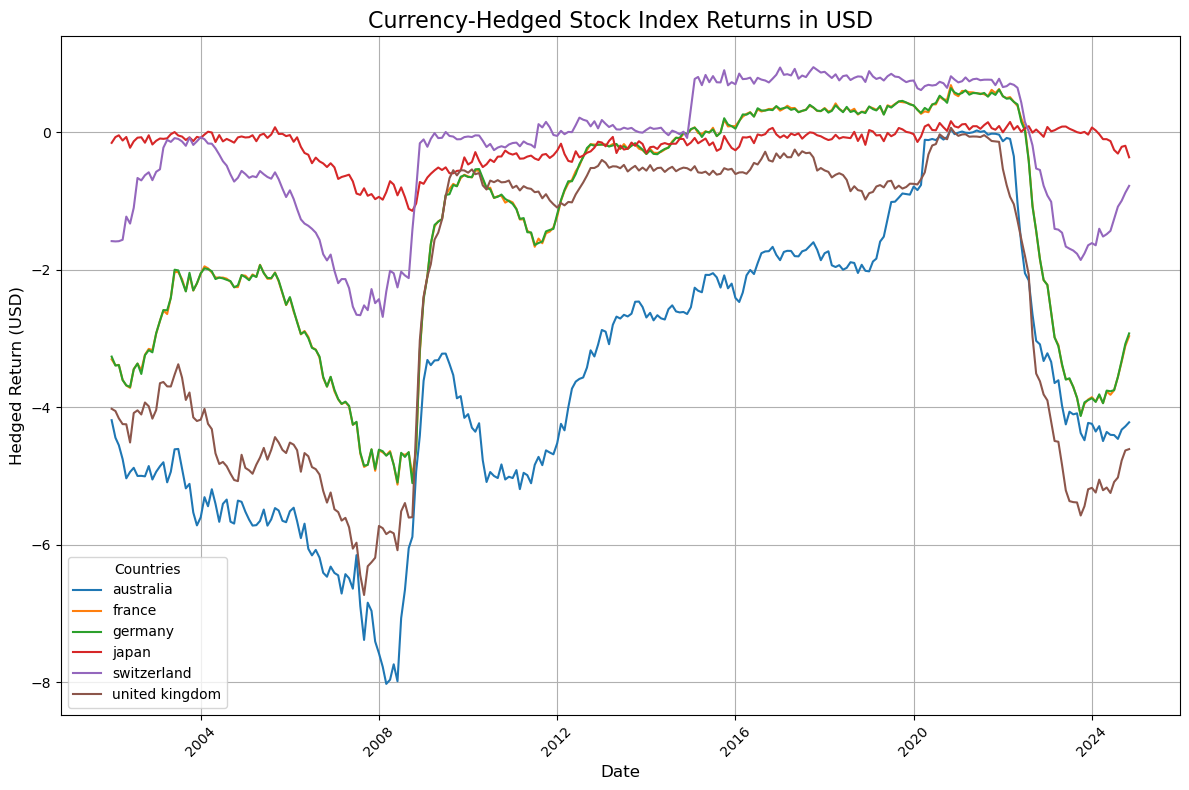

In [75]:
# Plot the hedged returns for each country
plt.figure(figsize=(12, 8))

# Loop through each country to plot the corresponding hedged return
for country in country_map.keys():
    hedged_col = f"{country}_hedged_return_usd"
    if hedged_col in df_hedged.columns:  # Ensure the column exists
        plt.plot(df_hedged["date"], df_hedged[hedged_col], label=country)

# Customize the plot
plt.title("Currency-Hedged Stock Index Returns in USD", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Hedged Return (USD)", fontsize=12)
plt.legend(title="Countries", loc="best")
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Array with all the non-usd currencies
currencies = ["AUD", "EUR", "JPY", "CHF", "GBP"]
fx_df = pd.read_csv('../data/monthly_exchange_rate/merged_monthly_exchange_rates.csv', parse_dates=['date'])

for return_file in glob.glob("../data/monthly_returns/*.csv"):
    df = pd.read_csv(return_file, parse_dates=['date'])
    if 'currency' in df.columns:
        if df['currency'].iloc[0] in currencies:
            curr = df['currency'].iloc[0]
            fx_col = f'USD_per_{curr}'
        
            # To only keep month/year 
            df['month'] = df['date'].dt.to_period('M')
            fx_df['month'] = fx_df['date'].dt.to_period('M')
            df_merged = df[['month', 'currency', 'mportret', 'mportretx']].merge(fx_df[['month', fx_col]], on='month', how='inner')
            
            df_merged['mportret'] *= df_merged[fx_col]
            df_merged['mportretx'] *= df_merged[fx_col]
            
            # Save to new file
            df_merged.to_csv(return_file.replace("monthly_returns", f"converted_return"), index=False)

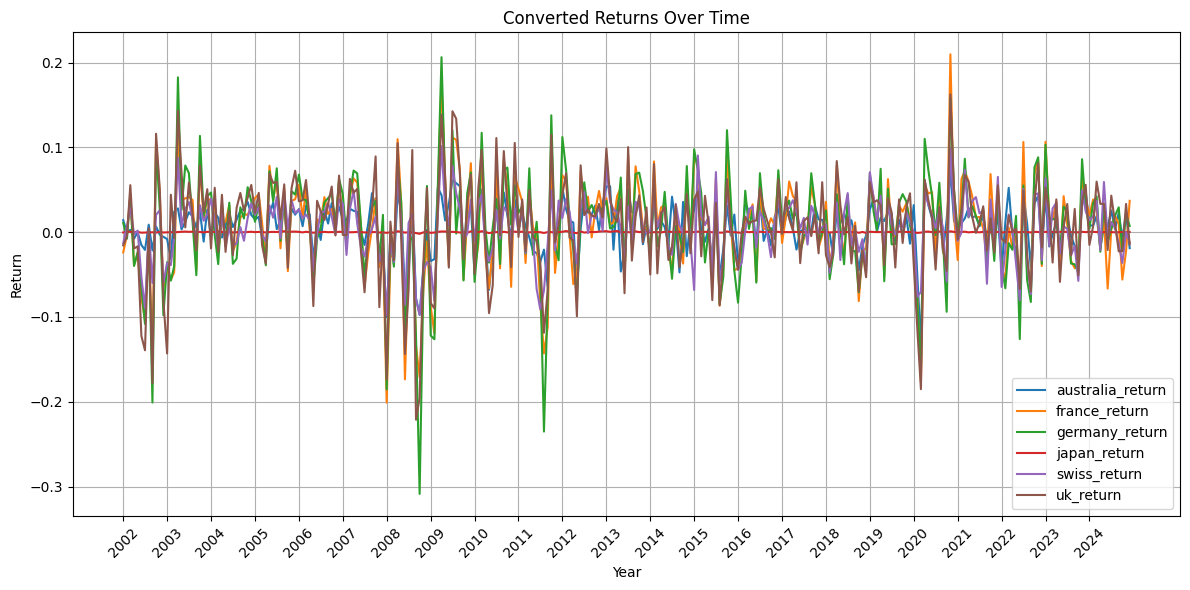

In [ ]:
# For the different countries (one plot for all the countries, see after what to do)
converted_files = glob.glob("../data/converted_return/*.csv")

plt.figure(figsize=(12, 6))
all_months=set()
for file in converted_files:
    df = pd.read_csv(file, parse_dates=['month'])
    
    
    # Aggregate mportret per month (optional if needed)
    df_grouped = df.groupby('month')['mportret'].mean().reset_index()
    plt.plot(df_grouped['month'], df_grouped['mportret'], label=os.path.basename(file).replace('.csv', ''))

    
    all_months.update(df_grouped['month'].unique())

# Select only 1 month per year for the x-axis ticks (e.g., January)
all_months = sorted(all_months)
selected_ticks = [m for m in all_months if m.month == 1]
# Shows only years
plt.xticks(selected_ticks, [m.strftime('%Y') for m in selected_ticks], rotation=45)
plt.title('Converted Returns Over Time')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

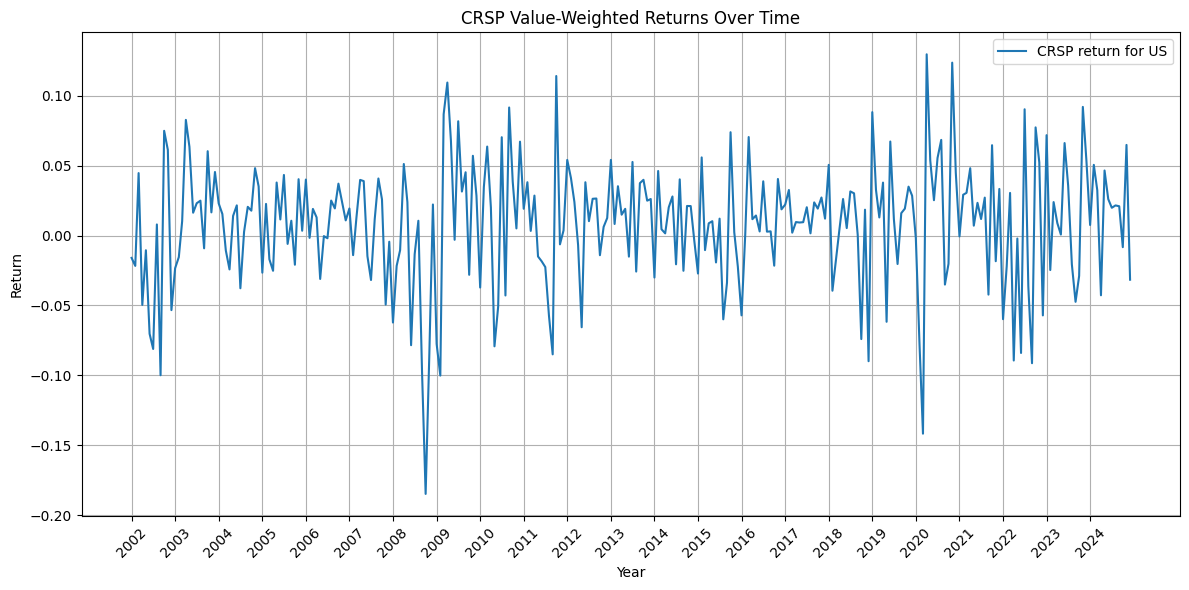

In [ ]:
#For US CSRP returns (basis to compare with the plot above)

df = pd.read_csv("../data/monthly_returns/csrp_return.csv", parse_dates=['date'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
df_grouped = df.groupby('month')['vwretd'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['month'], df_grouped['vwretd'], label='CRSP return for US')
all_months = df_grouped['month'].unique()
selected_ticks = [m for m in all_months if m.month == 1]
plt.xticks(selected_ticks, [m.strftime('%Y') for m in selected_ticks], rotation=45)

plt.title('CRSP Value-Weighted Returns Over Time')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()